In [1]:
import os
import numpy as np
import DataPreprocessing as DP
from matplotlib import pyplot as plt
from astropy.io import fits
import tensorflow as tf
from keras.models import Sequential
#from keras.layers import LSTM, Dense, Embedding, Input, Flatten
from keras import optimizers
from keras.models import Model

from keras.layers import Dense, Dropout, LSTM, Flatten, Input, Reshape
from keras.optimizers import Adam


import time
Tstart = time.time()

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0" #for GPU usagegpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
gpus = tf.config.experimental.list_physical_devices(device_type='XLA_GPU')
print(gpus)
tf.config.experimental.set_visible_devices(devices=gpus, device_type='XLA_GPU')

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]


In [3]:
#Dataset
#norm spectrum
kinds = ['boss_cv','boss_da+ms','boss_db','boss_db+ms','boss_dq','boss_dz','fgkm','hotstars','wd','wdsb2','yso','hotstars_m']
flux_cv, spectrum_cv = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[0]+'/'+'*.fit')
flux_dams, spectrum_dams = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[1]+'/'+'*.fit')
flux_db, spectrum_db = DP.Preprocessing7('/home/njl/ML/optical/'+kinds[2]+'/'+'*.fit')

#delate bad data
n = 0
for i in range(len(spectrum_db)):
    if len(spectrum_db[i][0]) < 4096:
        n = i
flux_db.pop(n)
spectrum_db.pop(n)

[array([5282.0195, 5283.235 , 5284.453 , 5285.669 , 5286.8877, 5288.104 ,
        5289.323 , 5290.54  , 5291.7573, 5292.9775, 5294.1953, 5295.416 ,
        5296.6343, 5297.8555, 5299.074 , 5300.2935, 5301.5156, 5302.7354,
        5303.958 , 5305.178 , 5306.4014, 5307.622 , 5308.8433, 5310.0674,
        5311.289 , 5312.5137, 5313.736 , 5314.9614, 5316.184 , 5317.407 ,
        5318.6333, 5319.857 , 5321.0835, 5322.3076, 5323.5347, 5324.76  ,
        5325.9844, 5327.213 , 5328.438 , 5329.667 , 5330.893 , 5332.122 ,
        5333.349 , 5334.5757, 5335.806 , 5337.0337, 5338.264 , 5339.492 ,
        5340.7236, 5341.952 , 5343.181 , 5344.413 , 5345.6426, 5346.8755,
        5348.1055, 5349.339 , 5350.5693, 5351.8003, 5353.034 , 5354.2656,
        5355.5005, 5356.7324, 5357.968 , 5359.2   , 5360.433 , 5361.6694,
        5362.903 , 5364.139 , 5365.3735, 5366.611 , 5367.845 , 5369.08  ,
        5370.3184, 5371.5537, 5372.7925, 5374.0283, 5375.2676, 5376.504 ,
        5377.744 , 5378.981 , 5380.218

In [4]:
#input spectrum
l_list =  flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db+flux_cv+flux_dams+flux_db
sl = []
for i in range(len(l_list)):
    sl.append(len(l_list[i]))
sl_min = np.min(sl)
X_train = []
for i in range(len(l_list)):
    X_train.append(l_list[i][0:sl_min])
X_train = np.array(X_train)
size = 4552
#X_train = l_list
X_train = np.stack(X_train)
#X_train = X_train.reshape(len(X_train),size,1) #change the shape to NHWC for CAE input
X_train = X_train.reshape(len(X_train),1,size)#(1214,1,4552)
print(X_train.shape) #print information of training samples

(9712, 1, 4552)


In [5]:
X_train.shape[1:]

(1, 4552)

In [6]:
#########################################model
#LSTM net
inputs = Input(shape=X_train.shape[1:])#(1214,4552)
x = LSTM(128,activation='tanh')(inputs)#(256)
x = Dropout(0.001)(x)#(256)
# = LSTM(512,activation='tanh')(x)#(128)
#x = Dropout(0.001)(x)#(128)
#x = LSTM(128,activation='tanh')(x)
# #hidden net
x = Dense(2048, activation='relu')(x)#(2048)
x = Dense(1024, activation='relu')(x)#(1024)
encoded = Dense(32, activation='relu', name='embedding')(x)#(2)
#x = Dense(128, activation='relu')(encoded)#(1024)
#x = Dense(2048, activation='relu')(x)#(2048)
x = Dense(1024, activation='relu')(encoded)
x = Dense(2048, activation='relu')(x)
decoded = Dense(4552, activation='softmax')(x)#(4552)
x = Reshape((1,4552))(decoded)#(1,4552)

In [7]:
autoencoder = Model(inputs, x)
#autoencoder = multi_gpu_model(input_spe, decoded)
optimizer_adam = optimizers.Adam(lr=0.001)#learning rate
autoencoder.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])####loss function
#autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(autoencoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 4552)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               2396672   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2048)              264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
embedding (Dense)            (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              33792 

In [8]:
Nepochs = 100 #number of epochs for CAE training
tosavemodel = True #if save the trained CAE model
plot_reconstruction = True #if plot the reconstruction comparison
 #setup if "tosavemodel=True" or "plot_reconstuction=True"

In [9]:
Tprocess0 = time.time()
print('\n', '## DATE PREPARATION RUNTIME:', Tprocess0-Tstart) #Timer

## MAIN ##
#training
H = autoencoder.fit(X_train, X_train,
                    batch_size = 512,
                    epochs=Nepochs,
                    verbose=2,
                    shuffle=True)

Tprocess1 = time.time()
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0) #Timer


 ## DATE PREPARATION RUNTIME: 43.07984972000122
Epoch 1/100
19/19 - 0s - loss: 34804.3125 - accuracy: 0.0081
Epoch 2/100
19/19 - 0s - loss: 33331.8047 - accuracy: 0.0145
Epoch 3/100
19/19 - 0s - loss: 32889.0352 - accuracy: 0.0242
Epoch 4/100
19/19 - 0s - loss: 32447.4199 - accuracy: 0.0324
Epoch 5/100
19/19 - 0s - loss: 32172.2734 - accuracy: 0.0459
Epoch 6/100
19/19 - 0s - loss: 31976.2480 - accuracy: 0.0653
Epoch 7/100
19/19 - 0s - loss: 31821.7949 - accuracy: 0.0806
Epoch 8/100
19/19 - 0s - loss: 31705.3242 - accuracy: 0.0937
Epoch 9/100
19/19 - 0s - loss: 31605.2910 - accuracy: 0.1002
Epoch 10/100
19/19 - 0s - loss: 31627.4199 - accuracy: 0.0942
Epoch 11/100
19/19 - 0s - loss: 31699.0879 - accuracy: 0.0846
Epoch 12/100
19/19 - 0s - loss: 31511.5293 - accuracy: 0.1050
Epoch 13/100
19/19 - 0s - loss: 31411.7754 - accuracy: 0.1058
Epoch 14/100
19/19 - 0s - loss: 31276.2773 - accuracy: 0.1103
Epoch 15/100
19/19 - 0s - loss: 31192.8477 - accuracy: 0.1075
Epoch 16/100
19/19 - 0s - loss

In [10]:
print('\n', '## AE TRAINING RUNTIME:', Tprocess1-Tprocess0)


 ## AE TRAINING RUNTIME: 38.529221296310425


/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


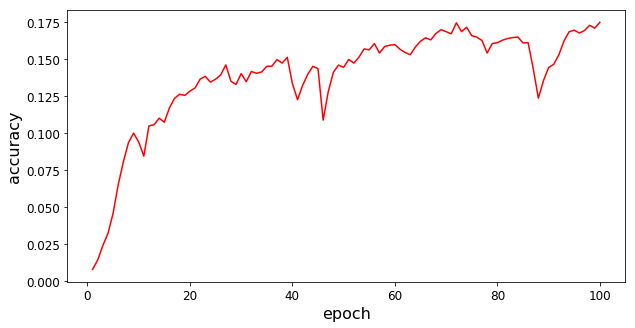

In [11]:
#plot loss function and accuracy function
acc = H.history['accuracy']
loss = H.history['loss']
plt.figure(figsize=[10,5])
font2 = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size' : 16,
    }

epochs = range(1,Nepochs+1)
 
#plt.title('Accuracy')
plt.plot(epochs, acc,'red')
plt.xlabel('epoch',font2)
plt.ylabel('accuracy',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

/home/njl/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


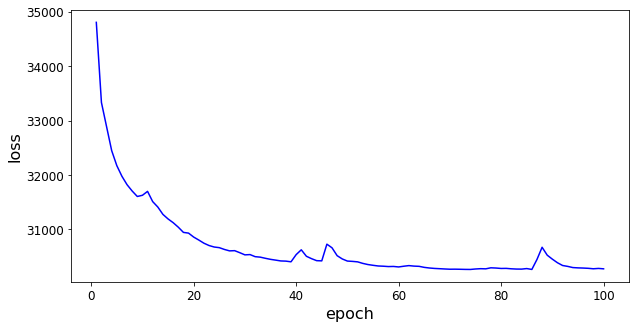

In [12]:
#plot loss function and accuracy function
 
#plt.title('Loss')
plt.figure(figsize=[10,5])
plt.plot(epochs, loss, 'blue')
plt.xlabel('epoch',font2)
plt.ylabel('loss',font2)
plt.tick_params(labelsize=12)

#plt.legend()
plt.show()

In [13]:
savename = 'LAE_reconstruction2.0'
tosavemodel = True
if tosavemodel:
    #restore the model
    autoencoder.save(savename + '.h5')